## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [4]:
len(df)

294478

c. The number of unique users in the dataset.

In [5]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [6]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [7]:
df.query('landing_page == "old_page" and group == "treatment"').shape[0] + df.query('landing_page == "new_page" and group == "control"').shape[0]

3893

f. Do any of the rows have missing values?

In [8]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
df.drop(df[(df['landing_page'] == 'old_page') & (df['group'] == 'treatment')].index,inplace = True)
df2 = df.drop(df[(df['landing_page'] == 'new_page') & (df['group'] == 'control')].index);

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2.drop([1899],inplace = True);

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2.converted.mean()

0.11959708724499628

In [16]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
control_mean = df2.query('group == "control"').converted.mean()
control_mean

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
treatment_mean = df2.query('group == "treatment"').converted.mean()
treatment_mean

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
# compute observed difference in conversion rate
obs_diff = treatment_mean - control_mean

# display observed difference
obs_diff

-0.0015782389853555567

In [20]:
len (df2.query('landing_page == "new_page"')) / len(df2)

0.5000619442226688

In [21]:
df2.shape[0]

290584

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

The results above are for a sample of the population and does not sufficiently reflect that of the population.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} - p_{old} \leq 0$$


$$H_1: p_{new} - p_{old} > 0$$


**$p_{old}$ and $p_{new}$ are conversion rates for the old and new page respectively.**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

We are assuming that $p_{new}$ and $p_{old}$ are equal to the converted success rate regardless of the page, and that they are to the converted rate.

In [22]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [23]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [24]:
n_new = df2.query('group == "treatment"').user_id.count()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [25]:
n_old = df2.query('group == "control"').user_id.count()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
new_page_converted = np.random.binomial(1, p_new, n_new)
p_new_sim = new_page_converted.mean()

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
old_page_converted = np.random.binomial(1, p_old, n_old)
p_old_sim = old_page_converted.mean()

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [28]:
p_new_sim - p_old_sim

0.00019759604201448344

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [29]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(1, p_new, n_new)
    p_new_sim = new_page_converted.mean()
    old_page_converted = np.random.binomial(1, p_old, n_old)
    p_old_sim = old_page_converted.mean()
    p_diffs.append(p_new_sim - p_old_sim)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

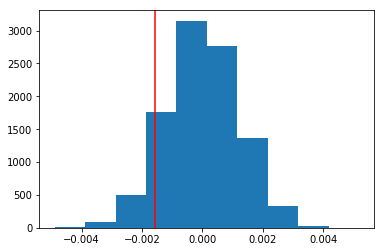

In [30]:
plt.hist(p_diffs);
plt.axvline(obs_diff, color='red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [31]:
obs_diff

-0.0015782389853555567

In [32]:
(p_diffs > obs_diff).mean()

0.90559999999999996

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**I have simulated the new page and old page conversion rates with 10000 independent trials and calulated the difference between the new and old page conversion rates for these 10000 trials, which I have stored in p_diffs. We are interested in how these simulated values in p_diffs differs from the actual data that was given as we have the difference between new and old page conversion rates stored in obs_diff.  The proportion of p_diffs that are greater the actual difference observed (obs_diff) is effectively known as the p-value the inequality direction of the null and alternative hypothesis.  Since the p-value is 0.905, we conclude that difference in conversion rates between the new page and old page is not statistically significant and therefore we fail to reject the null.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
import statsmodels.api as sm

convert_old = len(df2.query('group == "control" and converted==1'))
convert_new = len(df2.query('group == "treatment" and converted==1'))
n_old = df2.query('group == "control"').user_id.count()
n_new = df2.query('group == "treatment"').user_id.count()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [34]:
len(df2.query('group == "control" and converted==1'))

17489

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [35]:
sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')

(1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Z-score is a numerical measurement used in statistics of a value's relationship to the mean (average) of a group of values, measured in terms of standard deviations from the mean. If a Z-score is 0, it indicates that the data point's score is identical to the mean score. A Z-score of 1.0 would indicate a value that is one standard deviation from the mean. Z-scores may be positive or negative, with a positive value indicating the score is above the mean and a negative score indicating it is below the mean.  Quoted from https://www.investopedia.com/terms/z/zscore.asp**

**The p-value is consistent with my calculations in part J.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**We would be using a logistic regression here since we are working with a categorical variable that is either conversion or no conversion, or in other words, 1 or 0.  A logistic regression is used for predicting only 2 outcomes in the variable with the probability for each outcome bound between 0 and 1.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [36]:
df2['intercept'] = 1

In [37]:
df2[['control','treatment']] = pd.get_dummies(df2.group)

In [38]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


In [39]:
df2.drop(columns=['control'],inplace = True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [40]:
df2.rename(columns={"treatment": "ab_page"}, inplace = True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [41]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 14 Oct 2019   Pseudo R-squ.:               8.077e-06
Time:                        04:49:18   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [42]:
# Exponentiate the coefficents for interpretation
np.exp(-1.9888),np.exp(-0.015)

(0.13685955841614492, 0.98511193960306265)

With the coefficient values less than 1, it's beneficial to obtain the reciprical. This changes the direction from a unit increase to a unit decrease.

In [43]:
# Calculate inverse of exponentiation
1/np.exp(-1.9888),1/np.exp(-0.015)

(7.3067603868728614, 1.0151130646157189)

For every one unit decrease in ab_page, conversion is 1.015 times as likely, keeping all other variables constant.
From what we can observe this is not a big deal.

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br>

*The p-value is 0.19. In the case of the logistic regression, we are examining whether the new and old pages (as described in the ab_page variable) has a effect on conversion rate.  The null and alternative hypothesis is really a yes or no answer and can be expressed mathematically as the null hypothesis having an equal to and the alternative hypothesis having a not equal to statement. This in turn becomes a two-tailed test with the p-value being the summation of area under the each tail.*  <br />

*Since the p-value calculated with the model is 0.19, we know that the area under each tail is 0.19 / 2 = 0.095.<br /><br />  1 - (0.19 / 2) = 0.905<br /><br />
As we can see, this is very close the p-value calculated in part II.*

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

* *In an A/B test, we must consider the change aversion effect when existing users may give an unfair advantage to the old version simply because they are unhappy with change.  There is also a novelty effect when existing users may give an unfair advantage to the new version because they're excited to drawn to the change.<br /><br />*
* *Simpson’s paradox (https://www.thoughtco.com/what-is-simpsons-paradox-3126365) says that when we combine all of the groups together and look at the data in aggregate form, the correlation that we noticed before may reverse itself. This is most often due to lurking variables that have not been considered, but sometimes it is due to the numerical values of the data.<br /><br />*
* *Because of this phenomenon, it's always good idea to consider other factors that may influence the user's decision in our A/B testing case given the control and treatment groups.* <br /><br />
* *We may want to look at whether the time when the user visits the webpage (given in the timestamp column) has an effect on conversion rate. We can also look and see if being a weekday or weekend changes how users react on the old page and new page, or the number of times a user visits the page because converting.*<br /><br />
* *One disadvantage to adding additional terms into the regression model is these variables may be correlated, which makes interpretion difficult.  We need to make sure that we remove variables that are correlated with each other in the model.*

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [44]:
dfc = pd.read_csv('countries.csv')
dfc.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [45]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [46]:
df2c = df2.merge(dfc, on='user_id', how='inner')
df2c.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [47]:
# Make sure there are no blank entries
df2c.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
intercept       0
ab_page         0
country         0
dtype: int64

In [48]:
df2c.country.unique()

array(['US', 'CA', 'UK'], dtype=object)

In [49]:
df2c[['CA','UK','US']] = pd.get_dummies(df2c.country)
df2c.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


*Note that we have 3 countries total (CA, UK, US), and in order for accurate results from the logistic regression model, we only load in 2 countries at a time.  For example, I load in UK and US in my first run, which uses CA as a baseline in my analysis.  Subsequently I also ran the other 2 possible combinations (UK/CA and US/CA).*

In [50]:
log_mod = sm.Logit(df2c['converted'], df2c[['intercept', 'ab_page', 'UK', 'US']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 14 Oct 2019   Pseudo R-squ.:               2.323e-05
Time:                        04:49:19   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [51]:
# Since the coefficient of ab_page is negative, it's easier to explain using 1/np.exp(-0.0149)
1/np.exp(-0.0149), np.exp(0.0506), np.exp(0.0408)

(1.0150115583846535, 1.0519020483004984, 1.0416437559600236)

* *For every one unit decrease in new page, users are 1.015 times as likely to convert, with everything else being constant*
* *Users in UK is 1.052 times as likely to convert, with everything else being constant*
* *Users in US is 1.042 times as likely to convert, with everything else being constant* 
* *The p-values are 0.074 and 0.13 for UK and US respectively.  We can say that they are not statistically significant and we fail to reject the null* 


Now we can look at the model by loading in UK and CA.

In [52]:
log_mod = sm.Logit(df2c['converted'], df2c[['intercept', 'ab_page', 'UK', 'CA']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 14 Oct 2019   Pseudo R-squ.:               2.323e-05
Time:                        04:49:20   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
==============================================================================
"""

In [53]:
# Since the coefficient of ab_page is negative, it's easier to explain using 1/np.exp(-0.0149)
1/np.exp(-0.0149), np.exp(0.0099), 1/np.exp(-0.0408)

(1.0150115583846535, 1.0099491671175422, 1.0416437559600236)

* *For every one unit decrease in new page, users are 1.015 times as likely to convert, with everything else being constant*
* *Users in UK is 1.01 times as likely to convert, with everything else being constant*
* *Users in Canada is 1.042 times as likely to convert, with everything else being constant* 
* *The p-values are 0.457 and 0.13 for UK and CA respectively.  We can say that they are not statistically significant and we fail to reject the null.* 

Finally we load in US and CA into the model.

In [54]:
log_mod = sm.Logit(df2c['converted'], df2c[['intercept', 'ab_page', 'US', 'CA']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 14 Oct 2019   Pseudo R-squ.:               2.323e-05
Time:                        04:49:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US            -0.0099      0.013     -0.743      0.457      -0.036       0.016
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
==============================================================================
"""

In [55]:
# Since the coefficient of ab_page is negative, it's easier to explain using 1/np.exp(-0.0149)
1/np.exp(-0.0149), 1/np.exp(-0.0099), 1/np.exp(-0.0506)

(1.0150115583846535, 1.009949167117542, 1.0519020483004984)

* *For every one unit decrease in new page, users are 1.015 times as likely to convert, with everything else being constant*
* *Users in US is 1.01 times as likely to convert, with everything else being constant*
* *Users in Canada is 1.051 times as likely to convert, with everything else being constant* 
* *The p-values are 0.457 and 0.074 for US and CA respectively.  We can say that they are not statistically significant and we fail to reject the null* 

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [56]:
# make copy of the df2c dataset and create interactions between ab_page and country, and then insert in new columns
df_int = df2c.copy()
df_int['ab_page_US'] = df_int.ab_page * df_int.US
df_int['ab_page_UK'] = df_int.ab_page * df_int.UK
df_int['ab_page_CA'] = df_int.ab_page * df_int.CA
df_int = df_int.drop(columns=['CA','US','UK'])
df_int.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,ab_page_US,ab_page_UK,ab_page_CA
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,0


*Again I run the Logit model 3 times for the 3 combinations of 2 countries.*

In [57]:
log_mod = sm.Logit(df_int['converted'], df_int[['intercept', 'ab_page', 'ab_page_UK', 'ab_page_US']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 14 Oct 2019   Pseudo R-squ.:               3.351e-05
Time:                        04:49:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                   0.06785
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0827      0.038     -2.176      0.030      -0.157      -0.008
ab_page_UK     0.0901      0.040      2.225      0.026       0.011       0.169
ab_page_US     0.0644      0.038      1.679      0.093      -0.011       0.140
==============================================================================
"""

In [58]:
log_mod = sm.Logit(df_int['converted'], df_int[['intercept', 'ab_page', 'ab_page_UK', 'ab_page_CA']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 14 Oct 2019   Pseudo R-squ.:               3.351e-05
Time:                        04:49:22   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                   0.06785
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0183      0.013     -1.449      0.147      -0.043       0.006
ab_page_UK     0.0257      0.019      1.363      0.173      -0.011       0.063
ab_page_CA    -0.0644      0.038     -1.679      0.093      -0.140       0.011
==============================================================================
"""

In [67]:
log_mod = sm.Logit(df_int['converted'], df_int[['intercept', 'ab_page', 'ab_page_US', 'ab_page_CA']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 14 Oct 2019   Pseudo R-squ.:               3.351e-05
Time:                        04:49:24   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                   0.06785
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page        0.0074      0.018      0.410      0.682      -0.028       0.043
ab_page_US    -0.0257      0.019     -1.363      0.173      -0.063       0.011
ab_page_CA    -0.0901      0.040     -2.225      0.026      -0.169      -0.011
==============================================================================
"""

*From the above 3 model runs, I examined the p-values for ab_page_US, ab_page_CA, and ab_page_UK. I find the p-values vary from 0.026, 0.093, to 0.173.   The two interaction variables that I can see having some sort of statistical significance would be ab_page_CA when I run US/CA and ab_page_UK when I run US/UK.  The other 4 p-values that I see from the 3 runs are above 0.05. From the results I cannot accurately conclude if there significant effects on conversion based on interaction between page and country.  Therefore I would fail to reject the null hypothesis.* 

In [59]:
df_int.corr(method='pearson')

,user_id,converted,intercept,ab_page,ab_page_US,ab_page_UK,ab_page_CA
user_id,1.000000,0.001769,NaN,-0.001745,0.000217,-0.002814,-0.000304
converted,0.001769,1.000000,NaN,-0.002432,-0.002563,0.001827,-0.003807
intercept,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ab_page,-0.001745,-0.002432,NaN,1.000000,0.734811,0.376626,0.160519
ab_page_US,0.000217,-0.002563,NaN,0.734811,1.000000,-0.276818,-0.117981
ab_page_UK,-0.002814,0.001827,NaN,0.376626,-0.276818,1.000000,-0.060471
ab_page_CA,-0.000304,-0.003807,NaN,0.160519,-0.117981,-0.060471,1.000000


In [60]:
df_us = df2.merge(dfc, on='user_id', how='inner')
df_us = df_us.query('country == "US"')
df_us.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [61]:
n_old = df_us.query('group == "control"').count()
n_old = n_old[0]
n_old

101716

In [62]:
convert_old = df_us.query('group == "control" and converted == 1').count()
convert_old = convert_old[0]
convert_old

12270

In [63]:
n_new = df_us.query('group == "treatment"').count()
n_new = n_new[0]
n_new

101903

In [64]:
convert_new = df_us.query('group == "treatment" and converted == 1').count()
convert_new = convert_new[0]
convert_new

12072

In [65]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.5051934564639167, 0.9338628264991603)

*The p-value is 0.934 and is greater than 0.05.  We should fail to reject the null hypothesis. Users from USA are not more likely to convert to a paid subscription is they use the new page, and that the old page is just as good as the new one.*

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [66]:
#from subprocess import call
#call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])